In [1016]:
#Import the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import json
import requests
import time
from bs4 import BeautifulSoup
import re

In [1017]:
#genre_dict line is to map the document with genre ID numbers but not numbers.
df_budget=pd.read_csv('tn.movie_budgets.csv.gz')
genre_dict = {"genres":[{"id":28,"name":"Action"},{"id":12,"name":"Adventure"},{"id":16,"name":"Animation"},{"id":35,"name":"Comedy"},{"id":80,"name":"Crime"},{"id":99,"name":"Documentary"},{"id":18,"name":"Drama"},{"id":10751,"name":"Family"},{"id":14,"name":"Fantasy"},{"id":36,"name":"History"},{"id":27,"name":"Horror"},{"id":10402,"name":"Music"},{"id":9648,"name":"Mystery"},{"id":10749,"name":"Romance"},{"id":878,"name":"Science Fiction"},{"id":10770,"name":"TV Movie"},{"id":53,"name":"Thriller"},{"id":10752,"name":"War"},{"id":37,"name":"Western"}]}
df_ratings=pd.read_csv('imdb.title.ratings.csv.gz')
df_basics=pd.read_csv('imdb.title.basics.csv.gz')
df_gross=pd.read_csv('bom.movie_gross.csv.gz')
df_name_basics=pd.read_csv('imdb.name.basics.csv.gz')
df_title_akas=pd.read_csv('imdb.title.akas.csv.gz')
df_TMDB=pd.read_csv('TMDB_cleaned.csv')
df_writers=pd.read_csv('Writersb.csv')

# Code 

Q: What are the Top Rated and Most Rated Films
We decided that aside from financial metrics like gross revenues, another important success metric is quality. User ratings is one of the ways we have defined quality, and we examined the average ratings of films on IMDB.com. One of the reasons we chose this source is that it had a large number of users contributing ratings to films. We also considered user ratings on The Movie Database webiste (TMDb) but decided not to use this data due to the comparatively lower number of user ratings per film. Of course the number of ratings can also be an important metric and we use it here as a rough proxy for film popularity. Note that this analysis was limited to English language films.

Importing Packages and Files

In [1441]:
pd.set_option('display.max_columns', 45)
pd.set_option('display.max_rows', 100)
Full = pd.read_csv("df_7.csv")

Understanding the Data Frame
First step is to understand the size, columns, and types of data that are contained in the dataframe. This dataframe is one that was the product of several merges, as I was originally planning to use some of the user rating data from TNDb and some from IMDB. We needed to get user ratings, movie names, and genres all into one dataframe from 2 different files. This dataframe started with about 14K rows.

In [1442]:
print(Full.shape)
print(Full.dtypes)
Full.head()

(14219, 39)
tconst              object
averagerating      float64
numvotes             int64
primary_title       object
original_title      object
start_year           int64
runtime_minutes    float64
genres              object
Animation            int64
Sport                int64
Mystery              int64
Action               int64
Comedy               int64
Documentary          int64
Romance              int64
News                 int64
War                  int64
Horror               int64
Fantasy              int64
Family               int64
Music                int64
Musical              int64
Sci-Fi               int64
History              int64
Biography            int64
Thriller             int64
Crime                int64
Adventure            int64
Drama                int64
id                   int64
release_date        object
title               object
vote_average       float64
vote_count           int64
Year                 int64
category            object
primary_name    

,tconst,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres,Animation,Sport,Mystery,Action,Comedy,Documentary,Romance,News,War,Horror,Fantasy,Family,Music,Musical,Sci-Fi,History,Biography,Thriller,Crime,Adventure,Drama,id,release_date,title,vote_average,vote_count,Year,category,primary_name,birth_year,death_year
0,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,188207,2014-01-10,The Legend of Hercules,4.5,805,2014,writer,Sean Hood,1966.0,NaN
1,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,188207,2014-01-10,The Legend of Hercules,4.5,805,2014,writer,Daniel Giat,1955.0,NaN
2,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,188207,2014-01-10,The Legend of Hercules,4.5,805,2014,writer,Giulio Steve,NaN,NaN
3,tt1094666,7.0,1613,The Hammer,Hamill,2010,108.0,"Biography,Drama,Sport",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,74447,2010-10-26,The Hammer,6.5,16,2010,writer,Eben Kostbar,NaN,NaN
4,tt1094666,7.0,1613,The Hammer,Hamill,2010,108.0,"Biography,Drama,Sport",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,74447,2010-10-26,The Hammer,6.5,16,2010,writer,Joseph McKelheer,NaN,NaN


EDA
First I took a look at some descriptive statistics and then tried a few visualizations to better see the central tendency and distribution of some of the key data (average ratings and number of ratings). Note that this helped me decide to proceed with just the IMDB data as it provided a better data set. Another advantage of using the IMDB data set is that they claim to have a weighted average score that helps filter out ballot stuffing. The below just shows the steps for the IMDB data set.

In [1443]:
Full.averagerating.nunique()

85

In [1444]:
Full.averagerating.isna().sum()

0

In [1445]:
Full.averagerating.describe()

count    14219.000000
mean         5.797173
std          1.324626
min          1.100000
25%          5.000000
50%          5.900000
75%          6.700000
max          9.500000
Name: averagerating, dtype: float64

In [1446]:
Full.numvotes.nunique()

4030

In [1447]:
Full.numvotes.isna().sum()

0

In [1448]:
Full.numvotes.describe().astype(int)

count      14219
mean       38723
std       104064
min            5
25%          198
50%         1403
75%        17596
max      1387769
Name: numvotes, dtype: int64

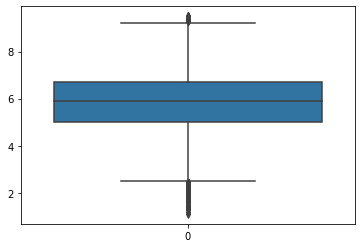

In [1449]:
# Visualize the average ratings a little bit: as a box plot (median of 6 and more outliers on the lower end)
boxplot = sns.boxplot(data=Full['averagerating'])
boxplot

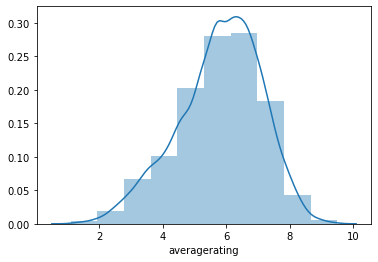

In [1450]:
# Visualize this a little bit: as distribution plot (a fairly normal distribution; slight skew to the left)
distplot = sns.distplot(a=Full["averagerating"], bins=10)
distplot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15d3c4370>]],
      dtype=object)

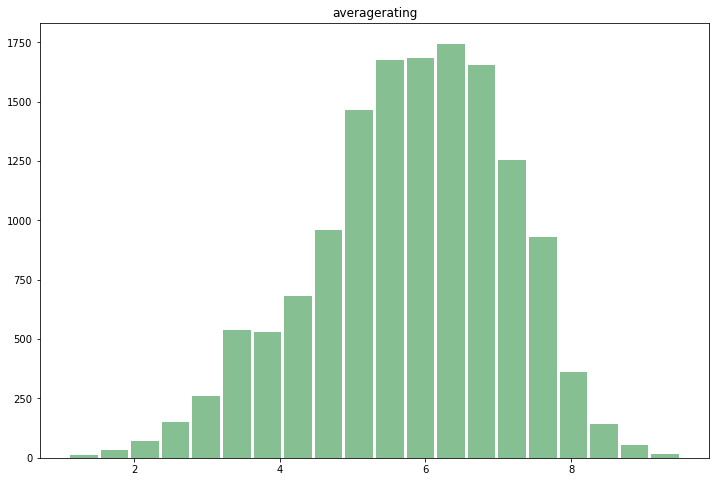

In [1451]:
# Trying a different method of histogram as a comparison and to familiarize with different libraries. 
Full.hist(column='averagerating', bins=20, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

Initial df Pruning
Next step is to cut down the df (from 39 to 5 columns) to make it easier to see and work with. These steps included:

1. Cut the df down to size for analysis of average rating and number of ratings
2. Limited the release date of the movies to a 5 year period (2013 to 2018)
3. Cut out movies with a low number of ratings (based on the IQR)
4. Drop duplicate movies in the df (based on similaries in all columns)
5. Sort primarily on average rating and secondarily on number of ratings.

In [1452]:
# Removing unnecesary columns
Ratings = Full[['Year', 'primary_title', 'genres', 'averagerating', 'numvotes']]
Ratings.head()

,Year,primary_title,genres,averagerating,numvotes
0,2014,The Legend of Hercules,"Action,Adventure,Fantasy",4.2,50352
1,2014,The Legend of Hercules,"Action,Adventure,Fantasy",4.2,50352
2,2014,The Legend of Hercules,"Action,Adventure,Fantasy",4.2,50352
3,2010,The Hammer,"Biography,Drama,Sport",7.0,1613
4,2010,The Hammer,"Biography,Drama,Sport",7.0,1613


In [1453]:
Ratings.Year.value_counts().sort_index()

2010    1082
2011    1382
2012    1280
2013    1734
2014    1697
2015    1862
2016    1851
2017    1793
2018    1538
Name: Year, dtype: int64

In [1454]:
# Limit the Years to a 5-year period: 2013 - 2018
Ratingsb = Ratings.loc[Ratings.Year >= 2013]
print(Ratingsb.shape)
Ratingsb.head()

(10475, 5)


,Year,primary_title,genres,averagerating,numvotes
0,2014,The Legend of Hercules,"Action,Adventure,Fantasy",4.2,50352
1,2014,The Legend of Hercules,"Action,Adventure,Fantasy",4.2,50352
2,2014,The Legend of Hercules,"Action,Adventure,Fantasy",4.2,50352
26,2015,Paradox,"Sci-Fi,Thriller",4.6,495
27,2015,Paradox,"Sci-Fi,Thriller",4.6,495


In [1455]:
# Do an initial sort of ratings and numvotes
Ratingsb.sort_values(['averagerating','numvotes'], ascending=[False, False])
Ratingsb.head()

,Year,primary_title,genres,averagerating,numvotes
0,2014,The Legend of Hercules,"Action,Adventure,Fantasy",4.2,50352
1,2014,The Legend of Hercules,"Action,Adventure,Fantasy",4.2,50352
2,2014,The Legend of Hercules,"Action,Adventure,Fantasy",4.2,50352
26,2015,Paradox,"Sci-Fi,Thriller",4.6,495
27,2015,Paradox,"Sci-Fi,Thriller",4.6,495


In [1456]:
# Data above is odd.. why a bunch of documentaries? 
# Lets look at just descending order for numvotes - as a gauge of popularity? 
Ratingsc= Ratingsb.sort_values(['numvotes'], ascending=False)
Ratingsc.head()

,Year,primary_title,genres,averagerating,numvotes
6130,2014,Interstellar,"Adventure,Drama,Sci-Fi",8.6,1299334
8954,2013,The Wolf of Wall Street,"Biography,Crime,Drama",8.2,1035358
8955,2013,The Wolf of Wall Street,"Biography,Crime,Drama",8.2,1035358
6339,2014,Guardians of the Galaxy,"Action,Adventure,Comedy",8.1,948394
6342,2014,Guardians of the Galaxy,"Action,Adventure,Comedy",8.1,948394


In [1457]:
# Ok, that helps... so now let me try and get rid of duplicates...see what that will do, before commiting to it
Ratingsc.primary_title.duplicated().sum()

5483

In [1458]:
# Ok, I will get rid of duplicates on the whole df
Ratingsd = Ratingsc.drop_duplicates(keep='first')
Ratingsd.head()

,Year,primary_title,genres,averagerating,numvotes
6130,2014,Interstellar,"Adventure,Drama,Sci-Fi",8.6,1299334
8954,2013,The Wolf of Wall Street,"Biography,Crime,Drama",8.2,1035358
6339,2014,Guardians of the Galaxy,"Action,Adventure,Comedy",8.1,948394
12453,2016,Deadpool,"Action,Adventure,Comedy",8.0,820847
1133,2015,Mad Max: Fury Road,"Action,Adventure,Sci-Fi",8.1,780910


Getting data ready for vizualization
Not sure if this was necessary, seemed that I needed a small df to indicate how many things should be in the plot. There is likely a way to select the number of rows to plot... but time was up.

In [1459]:
# Need to get data in shape for plotting...by cutting it down to 20 rows.
Ratingse = Ratingsd.iloc[0:20, :]
Ratingse.head()

,Year,primary_title,genres,averagerating,numvotes
6130,2014,Interstellar,"Adventure,Drama,Sci-Fi",8.6,1299334
8954,2013,The Wolf of Wall Street,"Biography,Crime,Drama",8.2,1035358
6339,2014,Guardians of the Galaxy,"Action,Adventure,Comedy",8.1,948394
12453,2016,Deadpool,"Action,Adventure,Comedy",8.0,820847
1133,2015,Mad Max: Fury Road,"Action,Adventure,Sci-Fi",8.1,780910


In [1460]:
# Changing the axis for plotting... saw an example of this in a video and assumed it would make the plotting work. 
Ratingse.set_index('primary_title', inplace=True)
Ratingse.head()

,Year,genres,averagerating,numvotes
primary_title,,,,
Interstellar,2014,"Adventure,Drama,Sci-Fi",8.6,1299334
The Wolf of Wall Street,2013,"Biography,Crime,Drama",8.2,1035358
Guardians of the Galaxy,2014,"Action,Adventure,Comedy",8.1,948394
Deadpool,2016,"Action,Adventure,Comedy",8.0,820847
Mad Max: Fury Road,2015,"Action,Adventure,Sci-Fi",8.1,780910


Getting a second plotting df ready
I created a second df for the second part of the question... which movies have the highest average customer rating. Similar steps were followed to limit the number of rows, column sorting, and getting rid of low number of votes to improve sorting.

In [1461]:
# 3rd approach to filter out lower values... this time it worked. 
Ratings_high = Ratingsd.loc[Ratingsd.numvotes >= 17596]
Ratings_high.head()

,Year,primary_title,genres,averagerating,numvotes
6130,2014,Interstellar,"Adventure,Drama,Sci-Fi",8.6,1299334
8954,2013,The Wolf of Wall Street,"Biography,Crime,Drama",8.2,1035358
6339,2014,Guardians of the Galaxy,"Action,Adventure,Comedy",8.1,948394
12453,2016,Deadpool,"Action,Adventure,Comedy",8.0,820847
1133,2015,Mad Max: Fury Road,"Action,Adventure,Sci-Fi",8.1,780910


In [1462]:
Ratings_high.shape

(959, 5)

In [1463]:
# Now to sort it on my 2 columns. 
Ratings_high.sort_values(['averagerating','numvotes'], ascending=[False, False], inplace=True)
Ratings_high.head()

<ipython-input-1463-8dec1eb3548c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ratings_high.sort_values(['averagerating','numvotes'], ascending=[False, False], inplace=True)


,Year,primary_title,genres,averagerating,numvotes
6130,2014,Interstellar,"Adventure,Drama,Sci-Fi",8.6,1299334
13968,2018,Avengers: Infinity War,"Action,Adventure,Sci-Fi",8.5,670926
7861,2018,Spider-Man: Into the Spider-Verse,"Action,Adventure,Animation",8.5,210869
8098,2017,Coco,"Adventure,Animation,Comedy",8.4,277194
2737,2014,The Hunt,Drama,8.3,242765


In [1464]:
# Need to get data in shape for plotting...limit rows
Ratings_high2 = Ratings_high.iloc[0:20, :]
Ratings_high2.head()

,Year,primary_title,genres,averagerating,numvotes
6130,2014,Interstellar,"Adventure,Drama,Sci-Fi",8.6,1299334
13968,2018,Avengers: Infinity War,"Action,Adventure,Sci-Fi",8.5,670926
7861,2018,Spider-Man: Into the Spider-Verse,"Action,Adventure,Animation",8.5,210869
8098,2017,Coco,"Adventure,Animation,Comedy",8.4,277194
2737,2014,The Hunt,Drama,8.3,242765


In [1465]:
# Changing the axis for plotting
Ratings_high2.set_index('primary_title', inplace=True)
Ratings_high2.head()

,Year,genres,averagerating,numvotes
primary_title,,,,
Interstellar,2014,"Adventure,Drama,Sci-Fi",8.6,1299334
Avengers: Infinity War,2018,"Action,Adventure,Sci-Fi",8.5,670926
Spider-Man: Into the Spider-Verse,2018,"Action,Adventure,Animation",8.5,210869
Coco,2017,"Adventure,Animation,Comedy",8.4,277194
The Hunt,2014,Drama,8.3,242765


Creating Visualizations for Presesntation
After considerable exploration and trying out both Seaborn and MatPlotLib, we found a format that did the basics. We worked together to ensure that we had similar dimensions and style for our presentation.

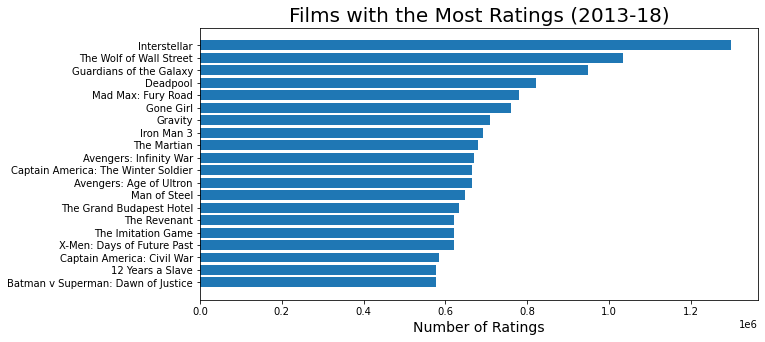

In [1466]:
Ratingse= Ratingse.sort_values('numvotes')
fig, ax = plt.subplots(figsize=(10, 5))

ax.barh(Ratingse.index, Ratingse['numvotes'])
ax.set_title('Films with the Most Ratings (2013-18)', fontsize=20)
ax.set_xlabel('Number of Ratings', fontsize=14)
plt.show()

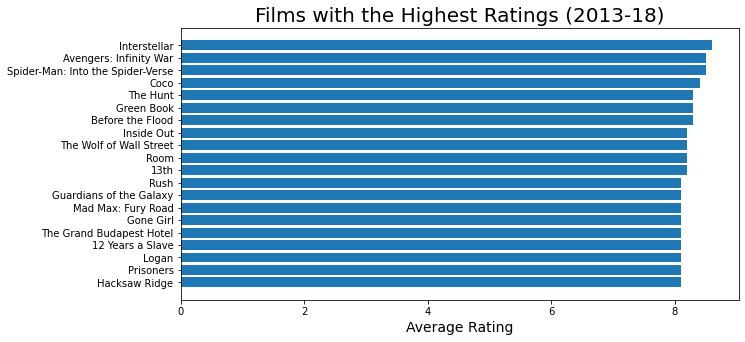

In [1467]:
Ratings_high2= Ratings_high2.sort_values('averagerating')
fig, ax = plt.subplots(figsize=(10, 5))

ax.barh(Ratings_high2.index, Ratings_high2['averagerating'])
ax.set_title('Films with the Highest Ratings (2013-18)', fontsize=20)
ax.set_xlabel('Average Rating', fontsize=14)
plt.show()

Based on the visualizations above, as well as the data frames, we make the following conclusions:

1. I have determined and displayed the 20 films with the highest average user rating on IMDB. All of these films have an average rating of 8.1 or higher (up to 8.6). This is on a 10-point scale.
2. I have determined and displayed the 20 films with the most user ratings on IMDB. These films range in number of votes from 576,909 to a high of 1,299,334. This measure can be thought of as a form of popularity.
3. 8 of the films appear on both of these Top 20 lists, indicating they are BOTH top rated and very popular. Interstellar is at the top of both lists, by quite a bit.
4. Inital investigation shows that slightly different genres of film appear in each list. The Top Rated films are more likely Dramas(11), Adventure(8), Action(6), Biography(5) or Comedy(5). Wheras many of the Top Popular films are Adventure(15), Action(12), Sci-Fi(11), and Drama(7).
5. These lists of the Top 20 in Quality and Popluarity provides a starting point for disecting what makes these films a success which will help our clients re-use elements that lead to this form of success.

Next, we will be observing the writers behind some of the top films in our dataset.

Q: Who Are the Writers for Top Grossing Films?
We believe that good writers are key to creating a succesful film. We wanted to find out who some of the writers are for the most succesful films. I decided to start by defining success by the finacial measure of domestic gross. So my goals was to get to a listing of writers for the Top 20 Films (based on domestic gross). We would then provide this list to our clients as writers they should approach to collaborate on future projects.

In [1468]:
pd.set_option('display.max_columns', 55)
pd.set_option('display.max_rows', 200)

In [1470]:
Full2 = pd.read_csv("df_8.csv")

Understanding the Data Frame
We want to make sure I understand the size, columns, and types of data that are contained in the dataframe. This dataframe is one that was the product of several merges, as we needed to get writers names, movie names, and financials all into one dataframe from 3 different files.

In [1472]:
print(Full2.shape)
print(Full2.dtypes)
Full2.head()

(6884, 80)
tconst                object
averagerating_x      float64
numvotes_x             int64
primary_title_x       object
original_title_x      object
start_year_x           int64
runtime_minutes_x    float64
genres_x              object
Animation_x            int64
Sport_x                int64
Mystery_x              int64
Action_x               int64
Comedy_x               int64
Documentary_x          int64
Romance_x              int64
News_x                 int64
War_x                  int64
Horror_x               int64
Fantasy_x              int64
Family_x               int64
Music_x                int64
Musical_x              int64
Sci-Fi_x               int64
History_x              int64
Biography_x            int64
Thriller_x             int64
Crime_x                int64
Adventure_x            int64
Drama_x                int64
id                     int64
release_date          object
title_x               object
vote_average_x       float64
vote_count_x           int64
Yea

,tconst,averagerating_x,numvotes_x,primary_title_x,original_title_x,start_year_x,runtime_minutes_x,genres_x,Animation_x,Sport_x,Mystery_x,Action_x,Comedy_x,Documentary_x,Romance_x,News_x,War_x,Horror_x,Fantasy_x,Family_x,Music_x,Musical_x,Sci-Fi_x,History_x,Biography_x,Thriller_x,Crime_x,...,numvotes_y,primary_title_y,original_title_y,start_year_y,runtime_minutes_y,genres_y,Animation_y,Sport_y,Mystery_y,Action_y,Comedy_y,Documentary_y,Romance_y,News_y,War_y,Horror_y,Fantasy_y,Family_y,Music_y,Musical_y,Sci-Fi_y,History_y,Biography_y,Thriller_y,Crime_y,Adventure_y,Drama_y
0,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,tt1094666,7.0,1613,The Hammer,Hamill,2010,108.0,"Biography,Drama,Sport",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,1613,The Hammer,Hamill,2010,108.0,"Biography,Drama,Sport",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,tt1094666,7.0,1613,The Hammer,Hamill,2010,108.0,"Biography,Drama,Sport",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,1613,The Hammer,Hamill,2010,108.0,"Biography,Drama,Sport",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


EDA
We counducted some EDA on domestic gross to better understand that data. This is placed in the appendix.

Initial df Pruning
I realized that the merges had created a MONSTER dataframe so first step was to cut it down to the columns I thought I might need; then to limit the films to a 5-year period; and also wanted to remove writers who had a death date listed (as not very helpful to reccomend dead writers for our client to work with).

In [1473]:
# Cutting down to just columns needed
Writers = Full2[['Year_x', 'primary_title_x', 'genres_x', 'averagerating_x', 'numvotes_x','production_budget', 'domestic_gross', 'profit', 'category', 'primary_name', 'birth_year', 'death_year']]
Writers.head()

,Year_x,primary_title_x,genres_x,averagerating_x,numvotes_x,production_budget,domestic_gross,profit,category,primary_name,birth_year,death_year
0,2014,The Legend of Hercules,"Action,Adventure,Fantasy",4.2,50352,70000000.0,18848538.0,-51151462.0,writer,Sean Hood,1966.0,NaN
1,2014,The Legend of Hercules,"Action,Adventure,Fantasy",4.2,50352,70000000.0,18848538.0,-51151462.0,writer,Daniel Giat,1955.0,NaN
2,2014,The Legend of Hercules,"Action,Adventure,Fantasy",4.2,50352,70000000.0,18848538.0,-51151462.0,writer,Giulio Steve,NaN,NaN
3,2010,The Hammer,"Biography,Drama,Sport",7.0,1613,850000.0,442638.0,-407362.0,writer,Eben Kostbar,NaN,NaN
4,2010,The Hammer,"Biography,Drama,Sport",7.0,1613,850000.0,442638.0,-407362.0,writer,Joseph McKelheer,NaN,NaN


In [1474]:
Writers.shape

(6884, 12)

In [1475]:
Writers.Year_x.value_counts().sort_index()

2010     662
2011     586
2012     503
2013     697
2014     755
2015    1268
2016    1106
2017     790
2018     517
Name: Year_x, dtype: int64

In [1476]:
# Limit the Years to a 5-year period: 2013 - 2018
Writersb = Writers.loc[Writers.Year_x >= 2013]
print(Writersb.shape)
Writersb.head()

(5133, 12)


,Year_x,primary_title_x,genres_x,averagerating_x,numvotes_x,production_budget,domestic_gross,profit,category,primary_name,birth_year,death_year
0,2014,The Legend of Hercules,"Action,Adventure,Fantasy",4.2,50352,70000000.0,18848538.0,-51151462.0,writer,Sean Hood,1966.0,NaN
1,2014,The Legend of Hercules,"Action,Adventure,Fantasy",4.2,50352,70000000.0,18848538.0,-51151462.0,writer,Daniel Giat,1955.0,NaN
2,2014,The Legend of Hercules,"Action,Adventure,Fantasy",4.2,50352,70000000.0,18848538.0,-51151462.0,writer,Giulio Steve,NaN,NaN
20,2013,The Adventurer: The Curse of the Midas Box,"Adventure,Family,Fantasy",5.4,5257,25000000.0,0.0,-25000000.0,writer,Matthew Huffman,1970.0,NaN
21,2013,The Adventurer: The Curse of the Midas Box,"Adventure,Family,Fantasy",5.4,5257,25000000.0,0.0,-25000000.0,writer,Christian Taylor,1968.0,NaN


In [1478]:
# Checking to see what type of duplication of rows exist. Yes, a lot of duplicates,
# but that is okay, as there are multiple writers per movie. 
Writersb.duplicated().sum()

2491

In [1479]:
Writersb.isna().sum()

Year_x                  0
primary_title_x         0
genres_x                0
averagerating_x         0
numvotes_x              0
production_budget       0
domestic_gross          0
profit                  0
category                0
primary_name            0
birth_year           3095
death_year           4814
dtype: int64

In [1480]:
# Removing films with a domestic gross of $0
Writersd = Writersb.loc[Writersb.domestic_gross != 0.0]

In [1481]:
Writersd.shape

(4257, 12)

In [1482]:
# Sort on domestic gross - this is our primary delector for top writers
Writerse= Writersd.sort_values(['domestic_gross'], ascending=False)
Writerse.head()

,Year_x,primary_title_x,genres_x,averagerating_x,numvotes_x,production_budget,domestic_gross,profit,category,primary_name,birth_year,death_year
1732,2018,Black Panther,"Action,Adventure,Sci-Fi",7.3,516148,200000000.0,700059566.0,500059566.0,writer,Joe Robert Cole,NaN,NaN
1733,2018,Black Panther,"Action,Adventure,Sci-Fi",7.3,516148,200000000.0,700059566.0,500059566.0,writer,Joe Robert Cole,NaN,NaN
1730,2018,Black Panther,"Action,Adventure,Sci-Fi",7.3,516148,200000000.0,700059566.0,500059566.0,writer,Stan Lee,1922.0,2018.0
1729,2018,Black Panther,"Action,Adventure,Sci-Fi",7.3,516148,200000000.0,700059566.0,500059566.0,writer,Jack Kirby,1917.0,1994.0
1728,2018,Black Panther,"Action,Adventure,Sci-Fi",7.3,516148,200000000.0,700059566.0,500059566.0,writer,Jack Kirby,1917.0,1994.0


Refining the df for Visualization
We tended to go back and forth between slicing down the df for better visualizion and refing to make sure it had the correct data (sort order, deduplication, etc). When we got stuck, we tried to forge ahead on something else. We wanted the final df to have only the data I was going to list or plot and only the two or three columns I needed to answer the question.

In [1483]:
# Need to get data in shape for plotting...limit rows to cover the top 20 grossing films
Writersg = Writerse.iloc[0:150, :]
Writersg.head()

,Year_x,primary_title_x,genres_x,averagerating_x,numvotes_x,production_budget,domestic_gross,profit,category,primary_name,birth_year,death_year
1732,2018,Black Panther,"Action,Adventure,Sci-Fi",7.3,516148,200000000.0,700059566.0,500059566.0,writer,Joe Robert Cole,NaN,NaN
1733,2018,Black Panther,"Action,Adventure,Sci-Fi",7.3,516148,200000000.0,700059566.0,500059566.0,writer,Joe Robert Cole,NaN,NaN
1730,2018,Black Panther,"Action,Adventure,Sci-Fi",7.3,516148,200000000.0,700059566.0,500059566.0,writer,Stan Lee,1922.0,2018.0
1729,2018,Black Panther,"Action,Adventure,Sci-Fi",7.3,516148,200000000.0,700059566.0,500059566.0,writer,Jack Kirby,1917.0,1994.0
1728,2018,Black Panther,"Action,Adventure,Sci-Fi",7.3,516148,200000000.0,700059566.0,500059566.0,writer,Jack Kirby,1917.0,1994.0


In [1484]:
# Simplify the df down to only necessary columns
Writersh = Writersg[['primary_title_x','domestic_gross','primary_name','death_year']]
Writersh.head()

,primary_title_x,domestic_gross,primary_name,death_year
1732,Black Panther,700059566.0,Joe Robert Cole,NaN
1733,Black Panther,700059566.0,Joe Robert Cole,NaN
1730,Black Panther,700059566.0,Stan Lee,2018.0
1729,Black Panther,700059566.0,Jack Kirby,1994.0
1728,Black Panther,700059566.0,Jack Kirby,1994.0


In [1486]:
Writersh.dtypes

primary_title_x     object
domestic_gross     float64
primary_name        object
death_year         float64
dtype: object

In [1487]:
Writersh.shape

(150, 4)

In [1488]:
# After some experimentation, was finally able to get rid of writers who had a death year listed. 
# Q: Have seen the pink band several times now, is it better to reassign to a variable rather than do "inplace"?
Writersh.drop(Writersh[Writersh['death_year'] < 2019].index, inplace = True)
Writersh.head()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,primary_title_x,domestic_gross,primary_name,death_year
1732,Black Panther,700059566.0,Joe Robert Cole,NaN
1733,Black Panther,700059566.0,Joe Robert Cole,NaN
6835,Avengers: Infinity War,678815482.0,Christopher Markus,NaN
6836,Avengers: Infinity War,678815482.0,Stephen McFeely,NaN
1466,Jurassic World,652270625.0,Amanda Silver,NaN


In [1489]:
# We always like to verify that a change actually worked, and what it did to the number of rows. 
Writersh.shape

(110, 4)

In [1490]:
Writersh.tail()

,primary_title_x,domestic_gross,primary_name,death_year
6264,Deadpool,363070709.0,Paul Wernick,NaN
4085,Inside Out,356461711.0,Brian Stewart,NaN
4089,Inside Out,356461711.0,Dylan Schaffer,NaN
4090,Inside Out,356461711.0,Dylan Schaffer,NaN
4082,Inside Out,356461711.0,Michael Arndt,NaN


In [1491]:
# Finally time to drop the rows that actually appear to be duplicates. 
# Want to drop those that are duplicated in BOTH title and name
Writersi = Writersh.drop_duplicates(subset=['primary_title_x', 'primary_name'], keep='first')
Writersi.head()

,primary_title_x,domestic_gross,primary_name,death_year
1732,Black Panther,700059566.0,Joe Robert Cole,NaN
6835,Avengers: Infinity War,678815482.0,Christopher Markus,NaN
6836,Avengers: Infinity War,678815482.0,Stephen McFeely,NaN
1466,Jurassic World,652270625.0,Amanda Silver,NaN
1467,Jurassic World,652270625.0,Derek Connolly,NaN


In [1492]:
Writersi.shape

(52, 4)

In [1493]:
# Yep, this is pretty much my answer right here. The top 20 grossing films and associated writers. 
Writersi.head()

,primary_title_x,domestic_gross,primary_name,death_year
1732,Black Panther,700059566.0,Joe Robert Cole,NaN
6835,Avengers: Infinity War,678815482.0,Christopher Markus,NaN
6836,Avengers: Infinity War,678815482.0,Stephen McFeely,NaN
1466,Jurassic World,652270625.0,Amanda Silver,NaN
1467,Jurassic World,652270625.0,Derek Connolly,NaN


In [1494]:
Writersi.primary_name.nunique()

46

Conclusions
Examining the final dataframe (a listing of the 20 Top Grossing films from 2013-18...based on domestic gross):

We have an associated list of 46 writers (try collaborating with these writers)
There are 6 of these writers who have worked on 2 of these films (perhaps really focus on these 6)
Most of films in this list have multiple writers (from 2 to 5 writers per film)
These films are not the Top Rated nor Most Rated, only 2 of these films appear in our other analysis. Note that the average rating for these films ranges from 8.5 to 6.2.

In [1495]:
# Simplify the df down to even fewer columns.
Writersj = Writersi[['primary_title_x','primary_name']]
Writersj.head()

,primary_title_x,primary_name
1732,Black Panther,Joe Robert Cole
6835,Avengers: Infinity War,Christopher Markus
6836,Avengers: Infinity War,Stephen McFeely
1466,Jurassic World,Amanda Silver
1467,Jurassic World,Derek Connolly


In [1496]:
# Set index to movie name (as this may make it easier to read and help for plotting)
# I realize I should rename the columns to make them clearer. 
Writersj.set_index('primary_title_x', inplace=True)
Writersj.head()

,primary_name
primary_title_x,
Black Panther,Joe Robert Cole
Avengers: Infinity War,Christopher Markus
Avengers: Infinity War,Stephen McFeely
Jurassic World,Amanda Silver
Jurassic World,Derek Connolly


In [1497]:
Writersj.shape

(52, 1)

In [1498]:
# Sort on the writer names will help show duplicates on writers names and movies they worked on 
# Ideally would sort on last name.
Writersj.sort_values(['primary_name'], ascending=True, inplace=True)
Writersj.head()

<ipython-input-1498-a0d601d10713>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Writersj.sort_values(['primary_name'], ascending=True, inplace=True)


,primary_name
primary_title_x,
Wonder Woman,Allan Heinberg
Jurassic World,Amanda Silver
The Jungle Book,Billy Frolick
The Jungle Book,Bob Hilgenberg
Finding Dory,Bob Peterson


Creating Visualizations for Presesntation
We ran out of time to figure out if there were good formatting options for Tables in our visualization libraries, so we decided to export the dataframes as csv, in hopes of working with them in Powerpoint or a spreadsheet. Will try and include an image of the final product if time permits.

In [1500]:
# Export these lists as CSV files to format in another program.
#Writersj.to_csv (r'/Users/markp/Desktop/writers_movies.csv', index = True, header=True)
#Writersi.to_csv (r'/Users/markp/Desktop/writers_movies_gross.csv', index = False, header=True)

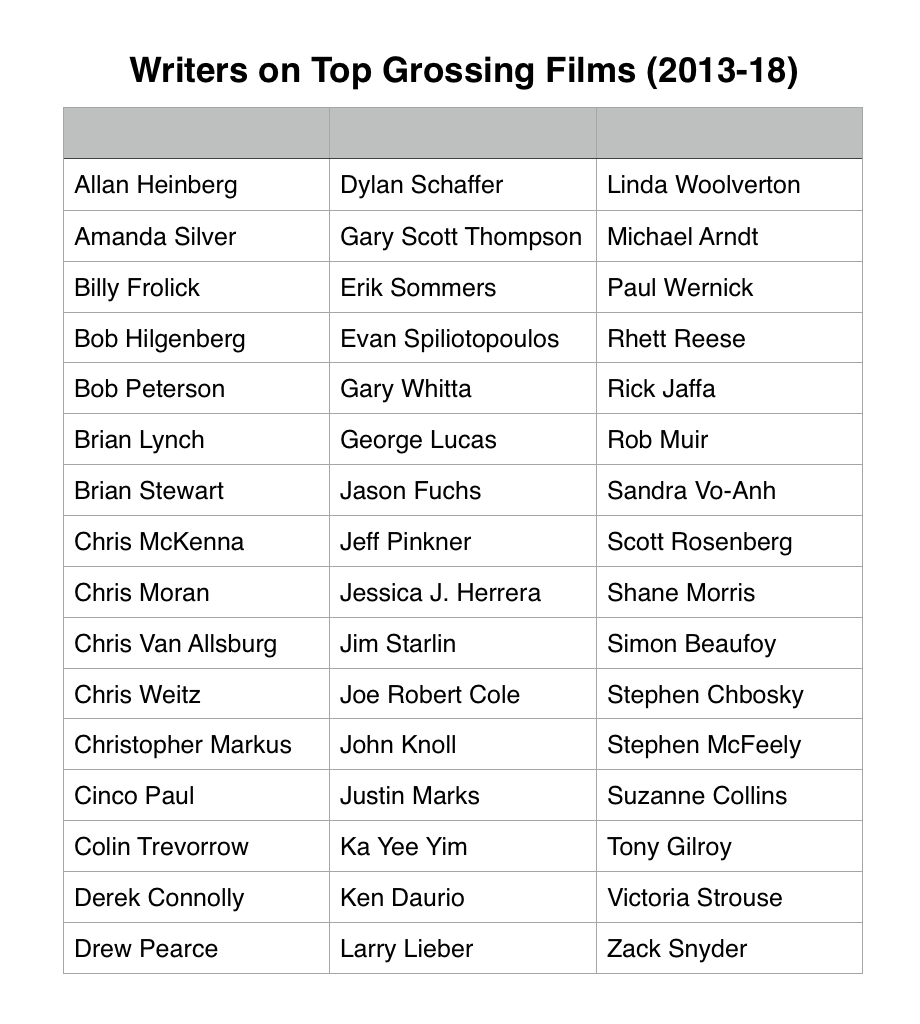

In [1501]:
from IPython.display import Image
Image(filename = "download.png", width = 600, height = 300)

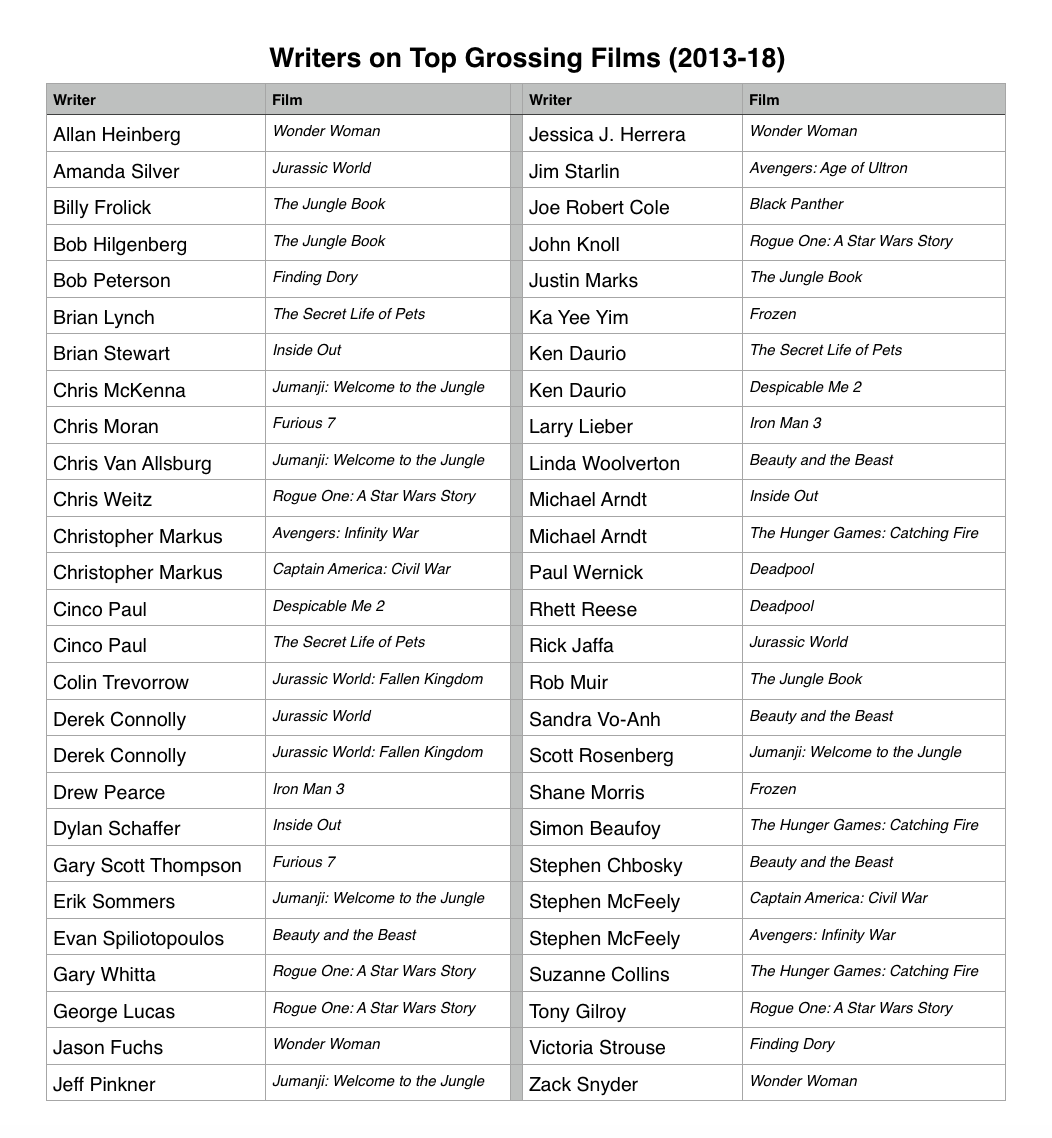

In [1503]:
Image(filename = "Top-Writers-Films.png", width = 600, height = 300)

In [1022]:
df_ratings_basics=df_ratings.merge(df_basics)
df_ratings_basics.sort_values(by='numvotes',ascending=False)

,tconst,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres
63498,tt1375666,8.8,1841066,Inception,Inception,2010,148.0,"Action,Adventure,Sci-Fi"
8738,tt1345836,8.4,1387769,The Dark Knight Rises,The Dark Knight Rises,2012,164.0,"Action,Thriller"
24920,tt0816692,8.6,1299334,Interstellar,Interstellar,2014,169.0,"Adventure,Drama,Sci-Fi"
38058,tt1853728,8.4,1211405,Django Unchained,Django Unchained,2012,165.0,"Drama,Western"
48221,tt0848228,8.1,1183655,The Avengers,The Avengers,2012,143.0,"Action,Adventure,Sci-Fi"
...,...,...,...,...,...,...,...,...
39180,tt8050582,8.0,5,Jackal Stories,Cuentos de chacales,2017,70.0,Documentary
33886,tt6449270,4.0,5,Chu lian wei man,Chu lian wei man,2013,105.0,"Drama,Romance"
22243,tt3819584,7.6,5,De onderkoning: strijd om de grondwet,De onderkoning: strijd om de grondwet,2014,51.0,Drama
49605,tt2136926,5.8,5,Fools,Fools,2011,77.0,"Action,Comedy,Horror"


In [1025]:
#genres=[]
#for f in df_ratings_basics:
#    for g in f.strip('[]').split(','):
#        if not g in genres:
#            genres.append(g)

In [1026]:
#genres=set(list(map(lambda x: x.strip(' '),genres)))

In [1027]:
#for g in genres:
#    df_ratings_basics[g]=df_ratings_basics.apply(lambda x: g in x)

In [1029]:
#Generating a list of all genres
#genres = set()
#for genre_string in df_ratings_basics['genres']:
#   genre_list = genre_string.split(',')
#   for genre in genre_list:
#       genres.add(genre)
#genres = list(genres)
#Made these comments after running this (do not want this to happen every time we run this cell).

In [1031]:
#for g in genres:
#    df_ratings_basics_new[g]=df_ratings_basics_new['genres'].apply(lambda x: g in x)

In [1032]:
df_topdf_ratings_basics_new[['Animation', 'Sport', 'Mystery', 'Action', 'Comedy', 'Documentary', 'Romance', 'News', 'War', 'Horror', 'Fantasy', 'Family', 'Music', 'Musical', 'Sci-Fi', 'History', 'Biography', 'Thriller', 'Crime', 'Adventure', 'Drama']]*=1

In [1035]:
df_ratings_basics_new=df_ratings_basics.dropna(subset=['genres'])

In [1296]:
#We do not want null values. This will help us address them (decided null runtime values were acceptable
#since those are unrelated to our analysis and recommendations).
df_ratings_basics_new.isna().sum()

tconst                0
averagerating         0
numvotes              0
primary_title         0
original_title        0
start_year            0
runtime_minutes    7332
genres                0
Animation             0
Sport                 0
Mystery               0
Action                0
Comedy                0
Documentary           0
Romance               0
News                  0
War                   0
Horror                0
Fantasy               0
Family                0
Music                 0
Musical               0
Sci-Fi                0
History               0
Biography             0
Thriller              0
Crime                 0
Adventure             0
Drama                 0
dtype: int64

In [1038]:
df_basics.head(100).sort_values('genres',ascending=False)
#How to deal with comma-separated genres and break those apart. Use different columns?
#Create 3 columns? Analysis on top genres/studios/writers would be helpful.

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
32,tt0293069,Dark Blood,Dark Blood,2012,86.0,Thriller
29,tt0283440,Short Time Heroes,Kurzzeithelden,2015,45.0,Sci-Fi
6,tt0112502,Bigfoot,Bigfoot,2017,NaN,"Horror,Thriller"
97,tt0431021,The Possession,The Possession,2012,92.0,"Horror,Mystery,Thriller"
51,tt0339736,The Evil Within,The Evil Within,2017,98.0,Horror
...,...,...,...,...,...,...
22,tt0253093,Gangavataran,Gangavataran,2018,134.0,NaN
35,tt0306058,Second Coming,Second Coming,2012,95.0,NaN
40,tt0326592,The Overnight,The Overnight,2010,88.0,NaN
44,tt0330811,Regret Not Speaking,Regret Not Speaking,2011,NaN,NaN


In [1039]:
df_gross_basics=df_basics.merge(df_gross, left_on='primary_title',right_on='title')
df_gross_basics.sort_values(['domestic_gross'], ascending=False)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,title,studio,domestic_gross,foreign_gross,year
1528,tt1825683,Black Panther,Black Panther,2018,134.0,"Action,Adventure,Sci-Fi",Black Panther,BV,700100000.0,646900000,2018
2876,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",Avengers: Infinity War,BV,678800000.0,"1,369.5",2018
9,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",Jurassic World,Uni.,652300000.0,"1,019.4",2015
2283,tt2527336,Star Wars: The Last Jedi,Star Wars: Episode VIII - The Last Jedi,2017,152.0,"Action,Adventure,Fantasy",Star Wars: The Last Jedi,BV,620200000.0,712400000,2017
2703,tt3606756,Incredibles 2,Incredibles 2,2018,118.0,"Action,Adventure,Animation",Incredibles 2,BV,608600000.0,634200000,2018
...,...,...,...,...,...,...,...,...,...,...,...
2083,tt2300975,Jessabelle,Jessabelle,2014,90.0,"Horror,Thriller",Jessabelle,LGF,NaN,7000000,2014
2322,tt2594078,Viral,Viral,2013,95.0,"Comedy,Horror,Thriller",Viral,W/Dim.,NaN,552000,2016
2323,tt2597892,Viral,Viral,2016,85.0,"Drama,Horror,Sci-Fi",Viral,W/Dim.,NaN,552000,2016
2324,tt3892200,Viral,Viral,2015,NaN,Horror,Viral,W/Dim.,NaN,552000,2016


In [1168]:
#Convert domestic gross into a number format so that we can do arithmetic with it.
df_budget['domestic_gross'] = df_budget['domestic_gross'].replace({'\$': '', ',': ''}, regex=True).astype(float)

In [1167]:
df_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,"$2,776,345,279",335507625.0
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,"$1,045,663,875",-169536125.0
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,"$149,762,350",-307237650.0
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,"$1,403,013,963",128405868.0
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,"$1,316,721,747",303181382.0


In [1044]:
#We need to get everything into a format that allows us to do arithmetic.
#Specifically, we are looking to subtract production budget from domestic gross to find the profit for each film.
df_budget['production_budget'] = df_budget['production_budget'].replace({'\$': '', ',': ''}, regex=True).astype(float)

In [1045]:
df_budget['profit'] = df_budget['domestic_gross'] - df_budget['production_budget']

In [1046]:
df_budget.sort_values('profit',ascending=False)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000.0,936662225.0,"$2,053,311,220",630662225.0
41,42,"Feb 16, 2018",Black Panther,200000000.0,700059566.0,"$1,348,258,224",500059566.0
42,43,"Dec 19, 1997",Titanic,200000000.0,659363944.0,"$2,208,208,395",459363944.0
3464,65,"May 25, 1977",Star Wars Ep. IV: A New Hope,11000000.0,460998007.0,"$786,598,007",449998007.0
33,34,"Jun 12, 2015",Jurassic World,215000000.0,652270625.0,"$1,648,854,864",437270625.0
...,...,...,...,...,...,...,...
31,32,"May 18, 2012",Battleship,220000000.0,65233400.0,"$313,477,717",-154766600.0
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,"$1,045,663,875",-169536125.0
12,13,"Jul 2, 2013",The Lone Ranger,275000000.0,89302115.0,"$260,002,115",-185697885.0
13,14,"Mar 9, 2012",John Carter,275000000.0,73058679.0,"$282,778,100",-201941321.0


In [1048]:
#df_budget_TMDB=df_budget.merge(df_TMDB, left_on='movie',right_on='title')
#Merging the budget and TMDB tables on the movie titles to get the information we need in one dataframe.
df_budget_TMDB.sort_values(['vote_count'], ascending=False)

,id_x,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,profit,id_y,release_date_y,title,vote_average,vote_count,Year
117,38,"Jul 16, 2010",Inception,160000000.0,292576195.0,"$835,524,642",132576195.0,27205,2010-07-16,Inception,8.3,22186,2010
484,56,"Feb 12, 2016",Deadpool,58000000.0,363070709.0,"$801,025,593",305070709.0,293660,2016-02-12,Deadpool,7.6,20175,2016
20,35,"Aug 14, 1998",The Avengers,60000000.0,23385416.0,"$48,585,416",-36614584.0,24428,2012-05-04,The Avengers,7.6,19673,2012
19,27,"May 4, 2012",The Avengers,225000000.0,623279547.0,"$1,517,935,897",398279547.0,24428,2012-05-04,The Avengers,7.6,19673,2012
110,32,"Nov 5, 2014",Interstellar,165000000.0,188017894.0,"$666,379,375",23017894.0,157336,2014-11-05,Interstellar,8.2,18597,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,43,"Apr 7, 2006",Simon,1300000.0,4055.0,"$1,738,663",-1295945.0,259712,2017-02-01,Simon,0.0,1,2017
1966,35,"May 22, 2009",The Girlfriend Experience,1300000.0,695840.0,"$1,005,840",-604160.0,496053,2014-10-05,The Girlfriend Experience,5.0,1,2014
1965,28,"Dec 31, 2014",House at the End of the Drive,1400000.0,0.0,$0,-1400000.0,280381,2014-01-11,House at the End of the Drive,8.0,1,2014
1067,43,"Jul 27, 2016",Nerve,20000000.0,38583626.0,"$70,652,284",18583626.0,455240,2011-12-07,Nerve,10.0,1,2011


In [1096]:
df_profit_genre=df_budget_TMDB.merge(df_ratings_basics_new,left_on='movie',right_on='primary_title')

In [1319]:
df_profit_genre_ranked=df_profit_genre.sort_values('profit',ascending=False)

Trying to make a master table with all columns we need. We would also like to ensure the lack of duplicate records.

In [1161]:
df_9.tconst.duplicated().sum()

2721

In [1162]:
df_9b = df_9.drop_duplicates(keep='first', subset='tconst')

Looking for correlations between average rating and various variables such as genre and domestic gross.
As we expect, one of the strongest positive correlations is between average rating and domestic gross.

In [1438]:
df_9b.corr()['averagerating'].sort_values(ascending=False).head(10)

averagerating        1.000000
vote_average         0.616414
numvotes             0.433461
vote_count           0.377074
runtime_minutes      0.344690
domestic_gross       0.274010
profit               0.208912
Biography            0.207274
Drama                0.204670
production_budget    0.199099
Name: averagerating, dtype: float64

In [1175]:
df_ratings_basics_new.sum(axis = 0, skipna = True) 

tconst             tt10356526tt10384606tt1042974tt1043726tt106024...
averagerating                                                 462487
numvotes                                                   260223835
primary_title      Laiye Je YaarianBorderlessJust InèsThe Legend ...
original_title     Laiye Je YaarianBorderlessJust InèsThe Legend ...
start_year                                                 147147287
runtime_minutes                                          6.22580e+06
genres             RomanceDocumentaryDramaAction,Adventure,Fantas...
Animation                                                       1743
Sport                                                           1179
Mystery                                                         3039
Action                                                          6988
Comedy                                                         17290
Documentary                                                    17753
Romance                           

In [1176]:
#Our work is not done, as we do not want to leave duplicate records in. More cleaning is required.
df_ratings_basics_nodups = df_ratings_basics_new.drop_duplicates(keep='first', subset='tconst')

In [1178]:
df_profit_analysis=df_budget_TMDB.merge(df_ratings_basics_nodups,left_on='movie',right_on='primary_title')

In [1211]:
#Looking for the top 20 grossing films since 2013.
df_top20=df_profit_analysis.sort_values('domestic_gross',ascending=False)

In [1286]:
df_top20.head(3)

,id_x,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,profit,id_y,release_date_y,title,...,Family,Music,Musical,Sci-Fi,History,Biography,Thriller,Crime,Adventure,Drama
46,42,2018-02-16,Black Panther,200000000.0,700059566.0,"$1,348,258,224",500059566.0,86841,2011-01-18,Black Panther,...,0,0,0,1,0,0,0,0,1,0
2,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,"$2,048,134,200",378815482.0,299536,2018-04-27,Avengers: Infinity War,...,0,0,0,1,0,0,0,0,1,0
25,34,2015-06-12,Jurassic World,215000000.0,652270625.0,"$1,648,854,864",437270625.0,135397,2015-06-12,Jurassic World,...,0,0,0,1,0,0,0,0,1,0


In [1221]:
#Getting rid of duplicates
df_top20.drop_duplicates(keep='first', subset='id_x', inplace=True)

In [1318]:
#Converted all release dates into a date format (originally were text format.)
#This format conversion allows us to filtering out dates from before 2013.
df_top20['release_date_x']=pd.to_datetime(df_top20.release_date_x)

In [1298]:
#Finalizing our list of the top 20 grossing films.
df_top20b = df_top20.loc[df_top20.Year >= 2013]

In [1291]:
df_top20c=df_top20b.head(20)

In [1292]:
#As we want, here are the top 20 grossing films.
#Please note that to test that only the top 20 were kept, we inserted a number
#greater than 20 in .head().
df_top20c.head(25)

,id_x,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,profit,id_y,release_date_y,title,...,Family,Music,Musical,Sci-Fi,History,Biography,Thriller,Crime,Adventure,Drama
46,42,2018-02-16,Black Panther,200000000.0,700059566.0,"$1,348,258,224",500059566.0,86841,2011-01-18,Black Panther,...,0,0,0,1,0,0,0,0,1,0
2,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,"$2,048,134,200",378815482.0,299536,2018-04-27,Avengers: Infinity War,...,0,0,0,1,0,0,0,0,1,0
25,34,2015-06-12,Jurassic World,215000000.0,652270625.0,"$1,648,854,864",437270625.0,135397,2015-06-12,Jurassic World,...,0,0,0,1,0,0,0,0,1,0
48,44,2018-06-15,Incredibles 2,200000000.0,608581744.0,"$1,242,520,711",408581744.0,260513,2018-06-15,Incredibles 2,...,0,0,0,0,0,0,0,0,1,0
50,45,2016-12-16,Rogue One: A Star Wars Story,200000000.0,532177324.0,"$1,049,102,856",332177324.0,330459,2016-12-16,Rogue One: A Star Wars Story,...,0,0,0,1,0,0,0,0,1,0
139,35,2017-03-17,Beauty and the Beast,160000000.0,504014165.0,"$1,259,199,706",344014165.0,10020,2012-01-13,Beauty and the Beast,...,1,1,1,0,0,0,0,0,0,0
51,46,2016-06-17,Finding Dory,200000000.0,486295561.0,"$1,021,215,193",286295561.0,127380,2016-06-17,Finding Dory,...,0,0,0,0,0,0,0,0,1,0
1,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,"$1,403,013,963",128405868.0,99861,2015-05-01,Avengers: Age of Ultron,...,0,0,0,1,0,0,0,0,1,0
217,38,2013-11-22,The Hunger Games: Catching Fire,130000000.0,424668047.0,"$864,868,047",294668047.0,101299,2013-11-22,The Hunger Games: Catching Fire,...,0,0,0,1,0,0,0,0,1,0
121,13,2018-06-22,Jurassic World: Fallen Kingdom,170000000.0,417719760.0,"$1,305,772,799",247719760.0,351286,2018-06-22,Jurassic World: Fallen Kingdom,...,0,0,0,1,0,0,0,0,1,0


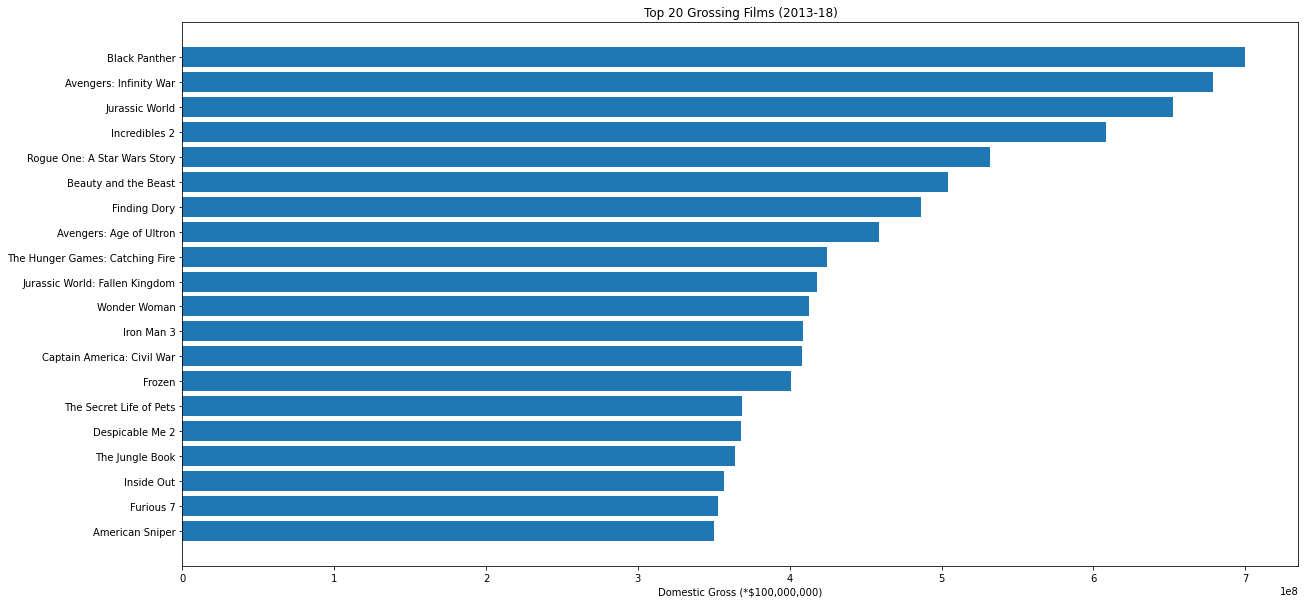

In [1435]:
#And now, putting the top 20 grossing films in bar graph form.
df_top20c = df_top20c.sort_values('domestic_gross')
fig, ax = plt.subplots(figsize=(20, 10))
ax.barh(df_top20c['movie'],df_top20c['domestic_gross'])
ax.set_title('Top 20 Grossing Films (2013-18)')
ax.set_xlabel('Domestic Gross (*$100,000,000)')
plt.show()

In [1253]:
#Next, we are finding the movie genres that are created most often.
df_profit_analysis.sum(axis = 0, skipna = True) 

id_x                                                            158641
release_date_x       May 20, 2011May 1, 2015Apr 27, 2018Nov 17, 201...
movie                Pirates of the Caribbean: On Stranger TidesAve...
production_budget                                          1.11464e+11
domestic_gross                                             1.43871e+11
worldwide_gross      $1,045,663,875$1,403,013,963$2,048,134,200$655...
profit                                                     3.24074e+10
id_y                                                         737709424
release_date_y       2011-05-202015-05-012018-04-272017-11-172017-1...
title                Pirates of the Caribbean: On Stranger TidesAve...
vote_average                                                   18950.4
vote_count                                                     4561888
Year                                                           6209176
tconst               tt1298650tt2395427tt4154756tt0974015tt0974015t...
averag

In [1264]:
df_profit_analysis_filter = df_profit_analysis.filter(['Animation', 'Sport', 'Mystery', 'Action', 'Comedy', 'Documentary', 'Romance', 'News', 'War', 'Horror', 'Fantasy', 'Family', 'Music', 'Musical', 'Sci-Fi', 'History', 'Biography', 'Thriller', 'Crime', 'Adventure', 'Drama'])

In [1267]:
df_profit_analysis_sum=df_profit_analysis_filter.sum()

In [1277]:
df_profit_analysis_sum.head(21)

Animation       153
Sport            76
Mystery         231
Action          662
Comedy          767
Documentary     185
Romance         349
News              3
War              38
Horror          404
Fantasy         190
Family          138
Music            89
Musical          22
Sci-Fi          214
History          81
Biography       223
Thriller        609
Crime           391
Adventure       481
Drama          1686
dtype: int64

In [1383]:
genredata = [['Animation', 153], ['Sport', 76], ['Mystery', 231],['Action',662],['Comedy',767],['Documentary',185],['Romance',185],['News',3],['War',38],['Horror',404],['Fantasy',190],['Family',138],['Music',89],['Musical',22],['Sci-Fi',214],['History',81],['Biography',223],['Thriller',609],['Crime',391],['Adventure',481],['Drama',1686]] 

In [1384]:
df_genredata = pd.DataFrame(genredata, columns = ['Genre', 'Quantity'])

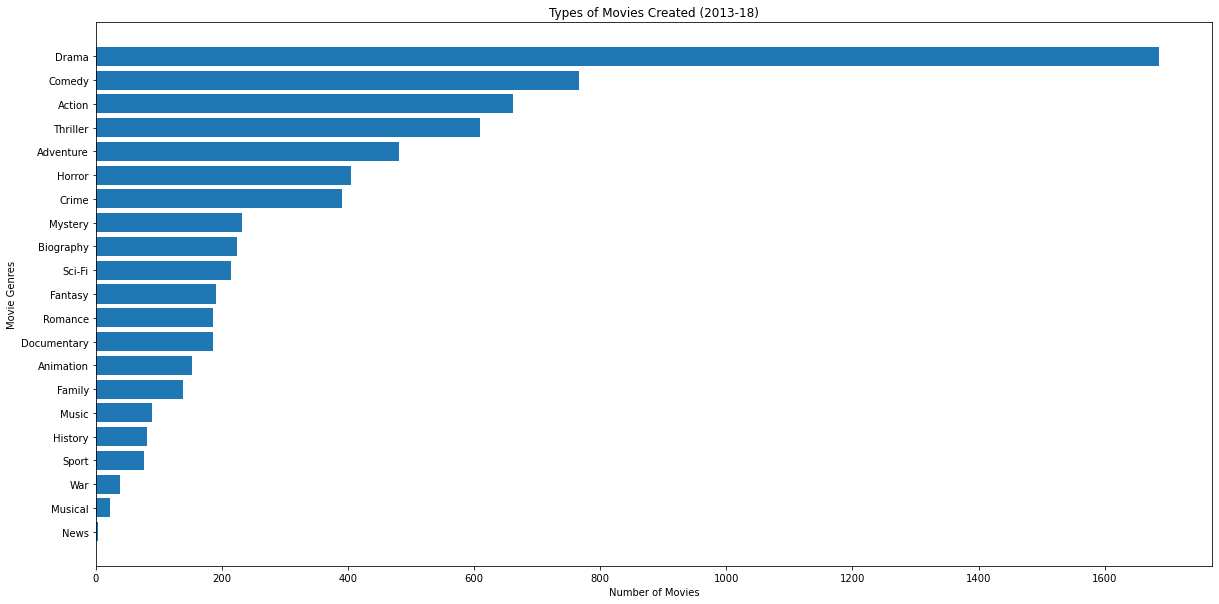

In [1436]:
#Finally, this will put the most frequently created movie genres in bar graph form.
df_genredata = df_genredata.sort_values('Quantity')
fig, ax = plt.subplots(figsize=(20, 10))
ax.barh(df_genredata['Genre'],df_genredata['Quantity'])
ax.set_title('Types of Movies Created (2013-18)')
ax.set_xlabel('Number of Movies')
ax.set_ylabel('Movie Genres')
plt.show()

Dramas are the most frequent type of movie created by a wide margin. As a result, it will
be more difficult to stand out against other companies. While it is acceptable to produce these,
we recommend diversifying and not relying on dramas as the main source of revenue.

In [1303]:
df_profit_analysis2.head()

,id_x,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,profit,id_y,release_date_y,title,...,Family,Music,Musical,Sci-Fi,History,Biography,Thriller,Crime,Adventure,Drama
1,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,"$1,403,013,963",128405868.0,99861,2015-05-01,Avengers: Age of Ultron,...,0,0,0,1,0,0,0,0,1,0
2,7,"Apr 27, 2018",Avengers: Infinity War,300000000.0,678815482.0,"$2,048,134,200",378815482.0,299536,2018-04-27,Avengers: Infinity War,...,0,0,0,1,0,0,0,0,1,0
3,9,"Nov 17, 2017",Justice League,300000000.0,229024295.0,"$655,945,209",-70975705.0,141052,2017-11-17,Justice League,...,0,0,0,0,0,0,0,0,1,0
5,10,"Nov 6, 2015",Spectre,300000000.0,200074175.0,"$879,620,923",-99925825.0,206647,2015-11-06,Spectre,...,0,0,0,0,0,0,1,0,1,0
8,12,"May 25, 2018",Solo: A Star Wars Story,275000000.0,213767512.0,"$393,151,347",-61232488.0,348350,2018-05-25,Solo: A Star Wars Story,...,0,0,0,0,0,0,0,0,1,0


In [1255]:
#We need to filter out movies from before 2013.
df_profit_analysis2=df_profit_analysis.loc[df_profit_analysis.Year >= 2013]

In [1256]:
df_profit_analysis2.head()

,id_x,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,profit,id_y,release_date_y,title,...,Family,Music,Musical,Sci-Fi,History,Biography,Thriller,Crime,Adventure,Drama
1,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,"$1,403,013,963",128405868.0,99861,2015-05-01,Avengers: Age of Ultron,...,0,0,0,1,0,0,0,0,1,0
2,7,"Apr 27, 2018",Avengers: Infinity War,300000000.0,678815482.0,"$2,048,134,200",378815482.0,299536,2018-04-27,Avengers: Infinity War,...,0,0,0,1,0,0,0,0,1,0
3,9,"Nov 17, 2017",Justice League,300000000.0,229024295.0,"$655,945,209",-70975705.0,141052,2017-11-17,Justice League,...,0,0,0,0,0,0,0,0,1,0
4,9,"Nov 17, 2017",Justice League,300000000.0,229024295.0,"$655,945,209",-70975705.0,141052,2017-11-17,Justice League,...,0,0,0,0,0,0,0,0,1,0
5,10,"Nov 6, 2015",Spectre,300000000.0,200074175.0,"$879,620,923",-99925825.0,206647,2015-11-06,Spectre,...,0,0,0,0,0,0,1,0,1,0


In [1257]:
#Dropping duplicates.
df_profit_analysis2.drop_duplicates(keep='first',subset='id_y',inplace=True)

<ipython-input-1257-891536fc50b4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_profit_analysis2.drop_duplicates(keep='first',subset='id_y',inplace=True)


In [1294]:
#Making sure that our updated table no longer has duplicates and releases from before 2013.
df_profit_analysis2.head(10)

,id_x,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,profit,id_y,release_date_y,title,...,Family,Music,Musical,Sci-Fi,History,Biography,Thriller,Crime,Adventure,Drama
1,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,"$1,403,013,963",128405868.0,99861,2015-05-01,Avengers: Age of Ultron,...,0,0,0,1,0,0,0,0,1,0
2,7,"Apr 27, 2018",Avengers: Infinity War,300000000.0,678815482.0,"$2,048,134,200",378815482.0,299536,2018-04-27,Avengers: Infinity War,...,0,0,0,1,0,0,0,0,1,0
3,9,"Nov 17, 2017",Justice League,300000000.0,229024295.0,"$655,945,209",-70975705.0,141052,2017-11-17,Justice League,...,0,0,0,0,0,0,0,0,1,0
5,10,"Nov 6, 2015",Spectre,300000000.0,200074175.0,"$879,620,923",-99925825.0,206647,2015-11-06,Spectre,...,0,0,0,0,0,0,1,0,1,0
8,12,"May 25, 2018",Solo: A Star Wars Story,275000000.0,213767512.0,"$393,151,347",-61232488.0,348350,2018-05-25,Solo: A Star Wars Story,...,0,0,0,0,0,0,0,0,1,0
9,13,"Jul 2, 2013",The Lone Ranger,275000000.0,89302115.0,"$260,002,115",-185697885.0,57201,2013-07-03,The Lone Ranger,...,0,0,0,0,0,0,0,0,1,0
12,17,"May 6, 2016",Captain America: Civil War,250000000.0,408084349.0,"$1,140,069,413",158084349.0,271110,2016-05-06,Captain America: Civil War,...,0,0,0,1,0,0,0,0,1,0
13,18,"Mar 25, 2016",Batman v Superman: Dawn of Justice,250000000.0,330360194.0,"$867,500,281",80360194.0,209112,2016-03-25,Batman v Superman: Dawn of Justice,...,0,0,0,0,0,0,0,0,1,0
15,21,"Dec 13, 2013",The Hobbit: The Desolation of Smaug,250000000.0,258366855.0,"$960,366,855",8366855.0,57158,2013-12-13,The Hobbit: The Desolation of Smaug,...,0,0,0,0,0,0,0,0,1,0
16,22,"Dec 17, 2014",The Hobbit: The Battle of the Five Armies,250000000.0,255119788.0,"$945,577,621",5119788.0,122917,2014-12-17,The Hobbit: The Battle of the Five Armies,...,0,0,0,0,0,0,0,0,1,0


In [1330]:
#Now, we will make a visual for how much revenue the average film of each genre generates at the box office.
#Specifically, we will be graphing the 21 genres based on average domestic gross.
genre_means=[df_profit_analysis2.groupby(genre).mean() for genre in genres]
means_df=pd.DataFrame
genres = list(genres)

In [1380]:
genre_means[20]

,id_x,production_budget,domestic_gross,profit,id_y,vote_average,vote_count,Year,averagerating,numvotes,...,Fantasy,Family,Music,Musical,Sci-Fi,History,Biography,Thriller,Crime,Adventure
Drama,,,,,,,,,,,,,,,,,,,,,
0,51.909091,5.459634e+07,7.196465e+07,1.736831e+07,268537.895623,5.954209,2224.880471,2015.215488,5.981481,100163.560606,...,0.102694,0.065657,0.015152,0.006734,0.129630,0.005051,0.026936,0.237374,0.117845,0.338384
1,50.694268,2.590876e+07,3.084340e+07,4.934633e+06,292611.635350,6.419108,1401.479299,2015.191083,6.431847,72799.839172,...,0.031847,0.033439,0.047771,0.003185,0.047771,0.062102,0.154459,0.124204,0.178344,0.074841


In [1382]:
domestic_gross_genre_data = [['Animation', 1.327373e+08], ['Sport', 3.933974e+07], ['Mystery', 3.283787e+07],['Action',8.853272e+07],['Comedy',5.719069e+07],['Documentary',1.692510e+07],['Romance',2.559664e+07],['News',5.083196e+07],['War',2.082258e+07],['Horror',2.437641e+07],['Fantasy',8.761713e+07],['Family',6.951566e+07],['Music',4.550650e+07],['Musical',1.169781e+08],['Sci-Fi',1.126618e+08],['History',3.267749e+07],['Biography',3.850066e+07],['Thriller',3.430735e+07],['Crime',3.353257e+07],['Adventure',1.221484e+08],['Drama',3.084340e+07]] 

In [1386]:
df_domestic_gross_genre_data = pd.DataFrame(domestic_gross_genre_data, columns = ['Genre', 'Average domestic gross'])

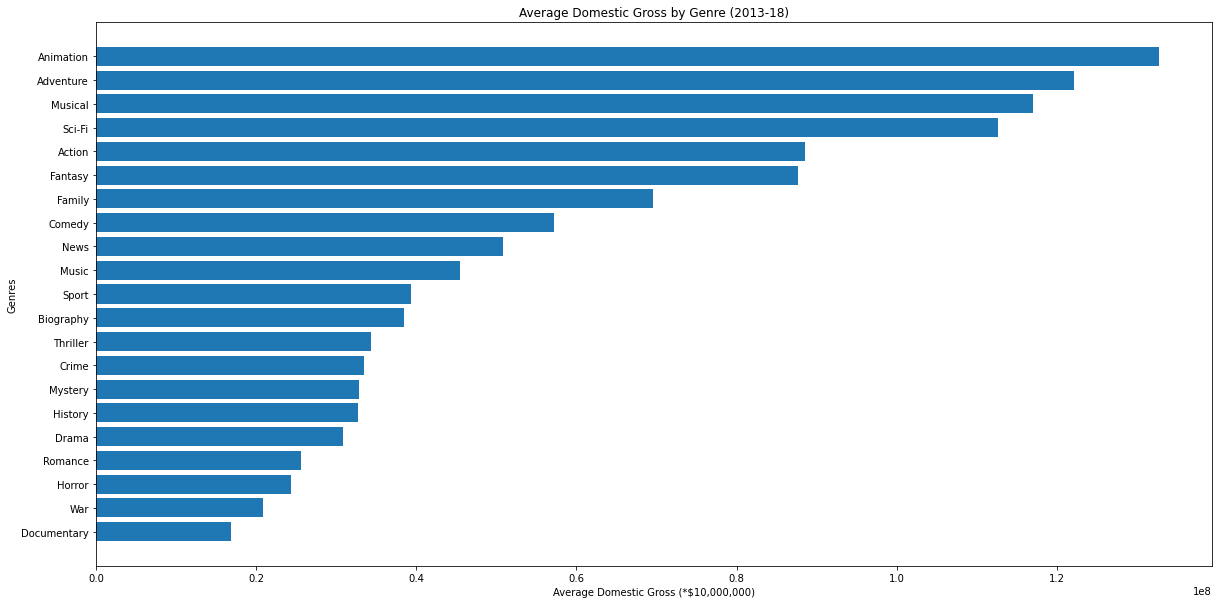

In [1437]:
#And now, putting the top 20 grossing films in bar graph form.
df_domestic_gross_genre_data = df_domestic_gross_genre_data.sort_values('Average domestic gross')
fig, ax = plt.subplots(figsize=(20, 10))
ax.barh(df_domestic_gross_genre_data['Genre'],df_domestic_gross_genre_data['Average domestic gross'])
ax.set_title('Average Domestic Gross by Genre (2013-18)')
ax.set_xlabel('Average Domestic Gross (*$10,000,000)')
ax.set_ylabel('Genres')
plt.show()

Based on this information, there is a ton of potenial for animation and adventure movies. By contrast, dramas are more difficult to succeed with, as they do not produce as good of results at the box office on average. Also, with how many dramas are being made, it is relatively difficult to make ones that stick out from the crowd.

With all of our analysis in mind, we have some recommendations for Microsoft as it enters this market. To summarize, we recommend that while dramas are highly rated and have a lot of potential, they do not average as much as most genres at the box office, and it is difficult to stand out from the many others being made. Instead, consider focusing on genres like animations and adventure films, which have a high average gross in a field that are not oversaturated with competition. In addition, sci-fi's numbers are also promising, and those films could fit in very nicely with Microsoft's brand. Exploring niche genres and becoming a leader for sci-fi films would be a practical goal for Microsoft. As for writers, it is best to work with those having a proven track record. With the right writers, Microsoft could stand out in any genre, even the crowded drama genre.

It is also worth noting that financials are just one measure of success. If Microsoft wishes to go after quality rather than gross, then dramas can be a good choice as are lesser earning genres like documentaries and biographies. 

A long-term recommendation that goes beyond the scope of our project relates to diversity. There is an opportunity for Microsoft to be a leader in diversity and inclusion by encouraging the production of niche genres and working with women and African American writers and other creators. Recruiting the top writers from underrepesented demographics could go a long way and serve as a way to attract audiences.